# Prediction of relevant protein kinase-cancer relations
We aim to learn pairs (x,y), where x is a protein kinase and y is a cancer that 
can be effectively treated by inhibiting x. We use word2vec to embed words found
in abstracts from the PubMed corpus. We then extract vectors that correspond to
both protein kinases and cancers. We use a positive set of (x,y) relations that
we have derived from an analysis of Clinical Trials data, and rank other possible
protein-kinase cancer relations.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
sys.path.insert(0, os.path.abspath('..'))
from kcet import KinasePredictor

## Input files
``embedding_Skipgram_dim100.npy`` is the result of word2vec embedding of pubmed. ``words.txt`` are the corresponding words. A directory of files was downloaded and softlinked to data using ``ln -s <path> data``.

In [3]:
data_directory = 'data'
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")
embedding_file = os.path.join(data_directory, "embedding_skipgram_dim100.npy")
words_file = os.path.join(data_directory, "words_before2021_jan3.txt")
predictor = KinasePredictor(embeddings=embedding_file, words=words_file)


[INFO] We ingested 279074 labeled word vectors from data/embedding_skipgram_dim100.npy and data/words_before2021_jan3.txt
[INFO] We ingested 522 symbol/NCBI gene id mappings from /home/peter/GIT/KCET/input/prot_kinase.tsv
[INFO] We ingested 694 meshId/disease mappings from /home/peter/GIT/KCET/input/neoplasms_labels.tsv



# PubMed Word Embeddings
The following code displays the numbers of word embeddings used as input.

In [4]:
embeddings = predictor.get_embeddings()
embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,8.434354,-1.301705,-0.096402,8.134256,1.920910,0.926111,-4.443069,1.682222,6.917873,1.928016,...,-4.835361,-2.297898,-1.920775,-0.465857,0.514665,3.127317,3.846459,-0.568883,3.231197,2.706048
patient,8.775193,-2.617628,0.749227,9.040712,1.679668,0.293989,-6.171941,3.743819,7.335784,2.977857,...,-3.589026,-2.087615,-1.168177,0.232110,-0.159556,4.528789,3.694627,0.023134,1.677531,2.749773
meshd009369,8.508118,-4.368992,-0.529461,8.065137,0.859943,1.024093,-5.529982,2.339031,7.453519,2.226591,...,-4.020745,-2.279984,-3.091373,-0.013547,0.403936,4.710061,5.096478,-0.771608,4.101520,2.822914
0,7.366462,-2.015644,0.103874,7.467220,2.352617,0.799381,-7.434361,2.850947,7.761542,3.999322,...,-3.143945,-2.406357,-2.340659,-0.079155,0.768798,2.829236,3.359030,-0.015921,3.031416,1.629173
study,8.567193,-2.818339,0.221348,8.043354,1.631235,0.741792,-3.279874,4.170556,6.876228,3.561809,...,-1.841853,-2.179760,-2.473173,-0.025654,0.555928,3.907662,4.981505,-0.832214,3.822674,3.205337
1,7.583968,-2.109892,0.214502,8.173003,2.933490,1.067659,-7.066524,3.176004,7.272000,3.110386,...,-4.579496,-2.205738,-2.728051,-0.125211,0.599284,2.556179,4.968330,-0.336085,2.986451,2.776476
use,7.321156,-2.785458,0.171793,8.160103,2.721854,0.969593,-3.915670,2.357934,6.701575,4.726286,...,-2.638177,-2.298312,-2.857692,0.150134,0.188761,4.116158,4.415405,0.901760,2.335893,4.292428
expression,9.497906,-1.364561,0.500421,6.641219,2.774784,1.020741,-6.060380,2.977110,6.882190,2.641258,...,-4.025249,-2.238170,-3.074528,-0.459901,0.529136,3.341378,4.136434,-1.235821,4.460450,1.680390
treatment,8.591584,-2.476367,0.094937,9.567238,2.024945,0.611976,-4.438549,1.876791,7.714788,2.450379,...,-4.772988,-2.155564,-3.019541,-0.467862,0.763366,3.840882,4.210606,-0.536046,2.139682,3.479037
2,7.556173,-1.805964,0.131593,8.280127,2.912882,0.739869,-6.492619,3.480263,7.298543,3.185261,...,-4.365758,-2.248591,-3.271618,-0.012547,0.517691,2.614578,4.921038,-0.063667,2.667942,2.940784


In [5]:
print("Total number of embeddings: ", len(embeddings))

Total number of embeddings:  279074


# Positive examples
Note that we need to rename the gene.id to gene_id upstream TODO

In [6]:
positive_examples = os.path.join(data_directory, "KCET_positive_2021.tsv")
positive_df = pd.read_csv(positive_examples,  sep= "\t")[["mesh_id", "gene.id"]]
positive_df = positive_df.rename(columns={"gene.id": "gene_id"})
positive_df.head()

,mesh_id,gene_id
0,meshd001943,ncbigene1019
1,meshd001943,ncbigene1021
2,meshd009396,ncbigene4921
3,meshd002289,ncbigene1956
4,meshd002289,ncbigene2064


In [7]:
print("%d positive examples" % len(positive_df))
print("%d embedded words in total" % len(predictor.get_embeddings()))

510 positive examples
279074 embedded words in total


# Difference vectors
We form difference vectors by substracting the word vectors for the protein kinases (in the column ``gene.id``)
from the corresponding vectors for the cancer (in the column ``mesh_id``). The following function in the
KCET package takes the dataframe shown above, finds the corrresponding vectors, substracts them, and
returns a new Pandas dataframe.

In [8]:
diff_vectors_pos = predictor.get_disease_kinase_difference_vectors(examples=positive_df)

[INFO] Extracted 351 kinase-cancer difference vectors
[INFO]	Initial data: 510 examples
[INFO]	Could not identify 0 gene ids
[INFO]	Could not identify 1 MeSH ids


In [9]:
diff_vectors_pos.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1019-meshd001943,0.216646,3.655876,1.071927,-0.722951,0.367680,0.465755,0.418794,-2.099517,-1.790263,-0.213371,...,-2.022566,-0.317103,-1.421989,-0.204653,0.463428,-0.242397,-0.491233,0.427644,-2.196168,1.819980
ncbigene1021-meshd001943,0.030452,3.720027,1.016965,-1.051610,0.024833,0.982127,0.489182,-2.534349,-1.814148,0.040062,...,-1.650203,-0.357809,-0.631133,-0.098130,0.589177,-0.401167,-0.898499,0.290497,-2.418543,1.837906
ncbigene4921-meshd009396,-2.670899,2.733067,-0.569561,-3.087993,-0.103932,-0.822189,2.730327,-0.055104,-1.066800,-0.691886,...,-0.827484,0.534198,3.701657,0.468604,0.684156,-0.799683,-1.548203,1.367404,0.015826,0.172598
ncbigene1956-meshd002289,-0.658227,1.228249,-0.556157,-0.571083,-0.107215,0.426374,0.671859,0.527287,-0.252452,1.403538,...,-1.924055,0.002242,0.494866,-0.138703,0.016181,-1.415368,0.792387,-0.136395,-0.910239,1.851647
ncbigene2064-meshd002289,-1.328087,-0.204334,-1.170295,-1.143805,-0.218962,0.010136,1.089562,1.061568,-0.133885,1.831318,...,-0.472625,-0.264935,0.501440,-0.217320,0.255144,-1.773365,1.888879,-0.586480,-1.102478,0.539014


In [10]:
print("%d total difference vectors were extracted." % len(diff_vectors_pos))

351 total difference vectors were extracted.


# Negative examples
Here, we process negative examples in the same way. TODO LINK TO EXPLANATION OF HOW WE MAKE POS AND NEG

In [11]:
negative_examples = os.path.join(data_directory, "KCET_negative_2021.tsv")
negative_df = pd.read_csv(negative_examples,  sep= "\t")[["mesh_id", "gene_id"]]
negative_df.head()

,mesh_id,gene_id
0,meshd000074723,ncbigene5599
1,meshd047688,ncbigene203447
2,meshd017253,ncbigene2185
3,meshd000232,ncbigene85443
4,meshd018305,ncbigene5292


In [12]:
print("%d negative examples" % len(negative_df))

5100 negative examples


In [13]:
diff_vectors_neg = predictor.get_disease_kinase_difference_vectors(examples=negative_df)

[INFO] Extracted 4715 kinase-cancer difference vectors
[INFO]	Initial data: 5100 examples
[INFO]	Could not identify 18 gene ids
[INFO]	Could not identify 29 MeSH ids


In [14]:
diff_vectors_neg.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene5599-meshd000074723,2.655529,0.504851,0.625748,1.518887,0.945556,0.548947,-2.198937,-0.326028,1.382686,0.638925,...,-2.161751,-0.056356,-1.717769,-0.699362,-0.622357,0.198742,0.420550,0.625391,1.434420,-0.377444
ncbigene203447-meshd047688,-1.678044,1.449732,-0.384489,-2.067419,-0.351659,-0.454225,1.441193,-1.080663,-1.493859,0.102219,...,1.337292,1.639545,0.725752,-0.420067,0.221270,-0.651651,-1.630625,0.486522,-1.047029,-0.520121
ncbigene2185-meshd017253,4.715750,-0.251379,0.055102,3.493889,1.913120,1.348085,-2.688731,1.778545,3.214343,1.446959,...,-2.307206,-2.017854,-1.561508,-0.247136,0.705275,2.155442,2.416265,-0.259953,1.370509,1.364926
ncbigene85443-meshd000232,-1.346377,1.916956,-0.440202,-1.386843,-1.183735,-0.441262,3.171287,-1.389849,-1.990137,0.173341,...,0.872434,1.502396,1.260150,0.176495,-0.537387,-0.513928,-1.705507,0.625129,-0.191481,-0.523272
ncbigene5292-meshd018305,0.779350,0.717966,-0.985452,-1.111991,-0.782443,-0.133464,2.868683,-0.082839,-0.340068,0.931564,...,-1.610746,-0.219597,1.374354,0.074545,0.528014,-0.384216,-0.134682,0.715625,0.642717,1.363432


# PCA visualization
To do PCA, we concatenate the positive and negative examples and label them so that we can visualize them using PCA.

In [15]:
combined = diff_vectors_pos.append(diff_vectors_neg)
print("[INFO] We combined positive (n=%d) and negative (n=%d) to the combined dataframe (%d)" % 
      (len(diff_vectors_pos), len(diff_vectors_neg), len(combined)))

[INFO] We combined positive (n=351) and negative (n=4715) to the combined dataframe (5066)


In [16]:
# vector with colors for the data points -- red for positive, blue for negative
cvec = [ "red" if i < len(diff_vectors_pos) else "blue" for i in range(len(combined))]

In [17]:
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [18]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(combined.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.66520655 0.03837253 0.03332321]


Text(0, 0.5, 'PC 2 (3.84%)')

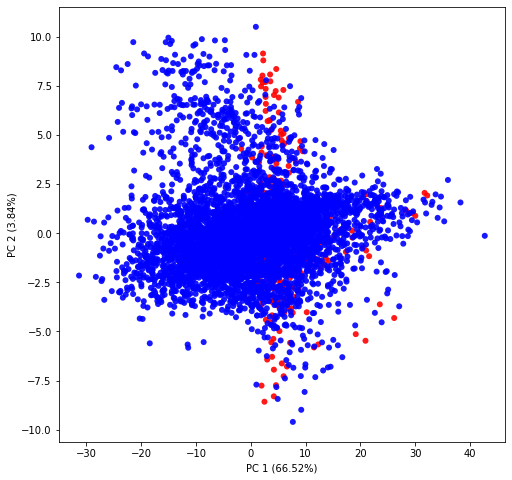

In [19]:
plt.figure(figsize=(8,8))
plt.scatter(pca_result[:,0], pca_result[:,1], c=cvec, edgecolor='', alpha=0.9)
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

# T-Distributed Stochastic Neighbouring Entities (t-SNE) Plot

In [20]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(combined)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5066 samples in 0.034s...
[t-SNE] Computed neighbors for 5066 samples in 3.153s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5066
[t-SNE] Computed conditional probabilities for sample 2000 / 5066
[t-SNE] Computed conditional probabilities for sample 3000 / 5066
[t-SNE] Computed conditional probabilities for sample 4000 / 5066
[t-SNE] Computed conditional probabilities for sample 5000 / 5066
[t-SNE] Computed conditional probabilities for sample 5066 / 5066
[t-SNE] Mean sigma: 2.610186
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.276016
[t-SNE] KL divergence after 300 iterations: 2.222076
t-SNE done! Time elapsed: 11.455251932144165 seconds


Text(0, 0.5, 'tsne-2d-two')

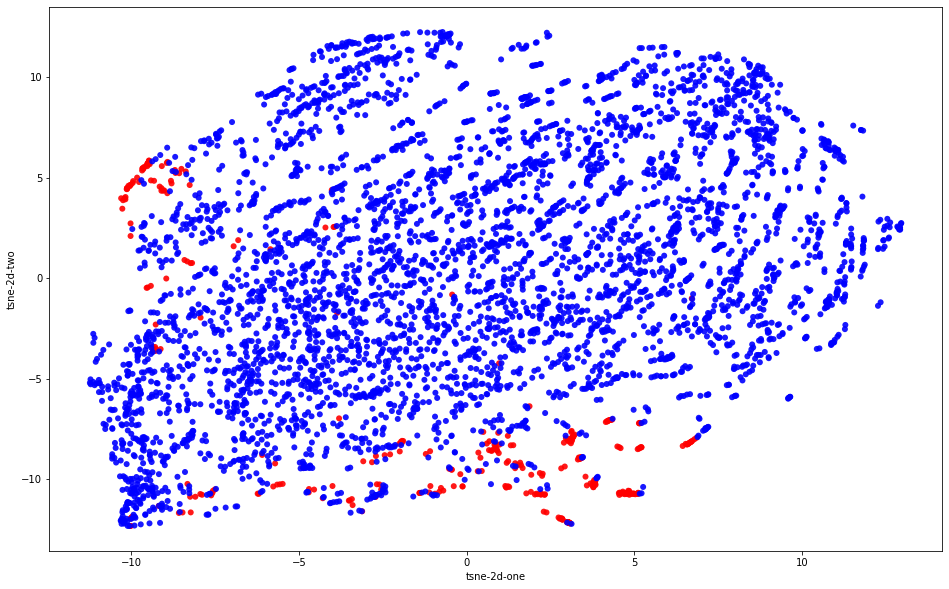

In [21]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cvec, edgecolor='', alpha=0.9)
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two') 

# Random forest

In [22]:
dark_kinase_list = pd.read_csv("dark_kinases.csv")["Gene"].to_list()
dark_kinase = set(dark_kinase_list)
print("There are {} dark kianses".format(len(dark_kinase)))

There are 31 dark kianses


In [23]:
dfd = pd.read_csv("dark_kinases.csv")

In [25]:
dfd.head()

,Unnamed: 0,Gene,Cancer,TDL,IDG_Status,Kinase_Score,Rank,Kinase_Type,Kinase_Group,Kinase_Family,Kinase_Protein,MOA_Targets
0,31,ADCK5,CHOL,Tdark,Understudied,45.83,3,protein kinase,Atypical group,ABC1 family,uncharacterized aarf domain-containing protein...,No
1,192,NRBP2,KIRC,Tdark,Understudied,39.58,20,protein kinase,other group,NRBP family,nuclear receptor-binding protein 2,No
2,46,ALPK3,COAD,Tdark,Understudied,38.10,3,protein kinase,Atypical group,Alpha family,alpha-protein kinase 3,No
3,114,ETNK2,COAD,Tdark,,38.10,4,Non-protein kinase,other small molecule kinase,choline/ethanolamine kinase,ethanolamine kinase 2,No
4,103,ETNK2,THCA,Tdark,,33.33,8,Non-protein kinase,other small molecule kinase,choline/ethanolamine kinase,ethanolamine kinase 2,No
